# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

from tqdm import tqdm

import os, torch
import torchvision.models as models

from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision.models as models

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


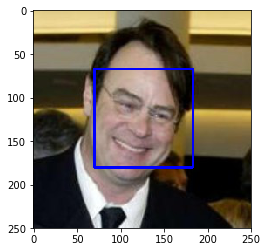

In [26]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

Detecting Human Faces in Human Dataset. 
Total human faces detected :  98 out of 100 human faces. 
Accuracy=  98.0 %

Detecting Human Faces in Dog Dataset. 
Total human faces detected :  17 out of 100 dog faces. 
Accuracy=  17.0 %

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def evaluateHaar(input_file):
    
    no_detected = 0

    for i in tqdm(range(len(input_file))):
        img = cv2.imread(input_file[i])
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        detected_faces = face_cascade.detectMultiScale(img_gray)

        if len(detected_faces) > 0:
            no_detected += 1
            
    return no_detected


# Detecting Human Faces in Human Dataset

no_detected = evaluateHaar(human_files_short)

print('Detecting Human Faces in Human Dataset')
print('Total human faces detected : ', no_detected, 'out of 100 human faces.')
print('Accuracy= ', no_detected/100*100, '%')


# Detecting Human Faces in Human Dataset

no_detected = evaluateHaar(dog_files_short)

print('Detecting Human Faces in Dog Dataset')
print('Total human faces detected : ', no_detected, 'out of 100 dog faces.')
print('Accuracy= ', no_detected/100*100, '%')

  0%|          | 0/100 [00:00<?, ?it/s]

Detecting Human Faces in Human Dataset
Total human faces detected :  98 out of 100 human faces.
Accuracy=  98.0 %


100%|██████████| 100/100 [01:24<00:00,  3.75it/s]

Detecting Human Faces in Dog Dataset
Total human faces detected :  17 out of 100 dog faces.
Accuracy=  17.0 %


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [4]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 115811699.24it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [3]:
def process_image(image_path):
    ''' Scales, crops, and normalizes an image into tensor format
        suitable for VVG-16 Model Configuration
    '''
    # Read Image File
    image = Image.open(image_path)
    
    # Extract Image Size
    width, height = image.size
    
    # Scale image to minimal dimension of 256
    if width > height:
        image = TF.resize(image,(int(width*256/height),256))
    else:
        image = TF.resize(image,(256,int(height*256/width)))
    
    # Center crop image to 224x224
    width, height = image.size
    new_width, new_height = 224, 224
    
    left = int((width - new_width)/2)
    top = int((height - new_height)/2)
    
    image = TF.crop(image, top, left, new_height, new_width)
    
    # Convert PIL Image to Tensor
    tensor_img = TF.to_tensor(image)
    
    # Image normalization
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    
    tensor_img = TF.normalize(tensor_img, norm_mean, norm_std).unsqueeze(0)
    
    
    return(tensor_img)

In [23]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Preprocess Input Image
    img = process_image(img_path)
    
    if use_cuda:
        img = img.cuda()
    
    # Inference the image
    prediction = VGG16(img)
    
    # Find The Predicted Index with The Highest Probability
    predicted_idx = torch.argmax(prediction)
    
    return predicted_idx.item() # predicted class index

# Test the Function
#prediction = VGG16_predict(dog_files[2])
#print(prediction)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [24]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
   
    prediction = VGG16_predict(img_path)
    
    if (prediction >= 151) and (prediction <= 268):
        return True
    else:
        return False
    
# Test the Function
#Flag = dog_detector(dog_files[2])
#print(Flag)

True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
Detecting Dog Faces in Human Dataset. 
Total dog faces detected :  2 out of 100 human faces. 
Accuracy :  2.0 %

Detecting Dog Faces in Dog Dataset. 
Total dog faces detected :  100 out of 100 dog faces. 
Accuracy :  100.0 %

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

def evaluateVGG16(input_file):
    
    no_detected = 0

    for i in tqdm(range(len(input_file))):
        if dog_detector(input_file[i]):
            no_detected += 1
            
    return no_detected

# Detecting Human Faces in Human Dataset

no_detected = evaluateVGG16(human_files_short)

print('Detecting Dog Faces in Human Dataset')
print('Total dog faces detected : ', no_detected, 'out of 100 human faces.')
print('Accuracy : ', no_detected/100*100, '%')


# Detecting Human Faces in Human Dataset

no_detected = evaluateVGG16(dog_files_short)

print('Detecting Dog Faces in Dog Dataset')
print('Total dog faces detected : ', no_detected, 'out of 100 dog faces.')
print('Accuracy : ', no_detected/100*100, '%')

  0%|          | 0/100 [00:00<?, ?it/s]

Detecting Dog Faces in Human Dataset
Total dog faces detected :  2 out of 100 human faces.
Accuracy :  2.0 %


100%|██████████| 100/100 [01:35<00:00,  1.02it/s]

Detecting Dog Faces in Dog Dataset
Total dog faces detected :  100 out of 100 dog faces.
Accuracy :  100.0 %


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [68]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Model Instatiation
another_model = models.squeezenet1_1(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    another_model = another_model.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [69]:
def another_model_predict(img_path):
    '''
    Use pre-trained another model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to another model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Preprocess Input Image
    img = process_image(img_path)
    
    if use_cuda:
        img = img.cuda()
    
    # Inference the image
    prediction = another_model(img)
    
    # Find The Predicted Index with The Highest Probability
    predicted_idx = torch.argmax(prediction)
    
    return predicted_idx.item() # predicted class index

# Test the Function
#prediction = another_model_predict(dog_files[10])
#print(prediction)

243


In [70]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_another_model(img_path):
    ## TODO: Complete the function.
   
    prediction = another_model_predict(img_path)
    
    if (prediction >= 151) and (prediction <= 268):
        return True
    else:
        return False
    
# Test the Function
#Flag = dog_detector_another_model(dog_files[0])
#print(Flag)

True


In [72]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

def evaluateOtherModel(input_file):
    
    no_detected = 0

    for i in tqdm(range(len(input_file))):
        if dog_detector_another_model(input_file[i]):
            no_detected += 1
            
    return no_detected

# Detecting Human Faces in Human Dataset

no_detected = evaluateOtherModel(human_files_short)

print('Detecting Dog Faces in Human Dataset')
print('Total dog faces detected : ', no_detected, 'out of 100 human faces.')
print('Accuracy : ', no_detected/100*100, '%')


# Detecting Human Faces in Human Dataset

no_detected = evaluateOtherModel(dog_files_short)

print('Detecting Dog Faces in Dog Dataset')
print('Total dog faces detected : ', no_detected, 'out of 100 dog faces.')
print('Accuracy : ', no_detected/100*100, '%')

  2%|▏         | 2/100 [00:00<00:06, 14.62it/s]

Detecting Dog Faces in Human Dataset
Total dog faces detected :  3 out of 100 human faces.
Accuracy :  3.0 %


100%|██████████| 100/100 [00:08<00:00, 13.89it/s]

Detecting Dog Faces in Dog Dataset
Total dog faces detected :  100 out of 100 dog faces.
Accuracy :  100.0 %


Detecting Dog Faces in Human Dataset. 
Total dog faces detected :  2 out of 100 human faces. 
Accuracy :  3.0 %

Detecting Dog Faces in Dog Dataset. 
Total dog faces detected :  100 out of 100 dog faces. 
Accuracy :  100.0 %

Squeezenet performed worse than VGG16. However, its inferencing speed was much higher than VGG16. It has really good bargain in design tradeoff as we can have significant improvement in speed with sacrificing slight accuracy.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [7]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = '/data/dog_images/train'
valid_dir = '/data/dog_images/valid'
test_dir = '/data/dog_images/test'

num_workers = 0
batch_size = 64

train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomRotation((80,100)),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
                                       

valid_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([ transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders = dict([('train',trainloader),
                ('valid',validloader),
                ('test',testloader)])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

- Cropping is used in my transform to have intact object proporsion as small difference in dog face shape can determine different breed). The best way to do cropping is by random position. By this random cropping we can have multiple image with the same object with different location making the model be able to generalize by position. After that, those cropped images are then resized to resolution 224x224 as all pretrained models require this resolution to work.

- My point was to have image with object with all orientation. However, extreem rotation such as 45 degrees deteriorates cropping process as the blank space gets into the cropped area. Therefore, I chose 0 and 90 degrees rotation with variation of +-10 degrees. To have 180 and 270 degrees rotation, I put vertical and horizontal flips. With all these configurations, I can have data augmentation with variations in object position and rotations. Color augmentation was not used as it would deteriorates color information of the dogs which is essential in this case.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [8]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## The Feature Extractor
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,64,3,padding=1)
        self.conv5 = nn.Conv2d(64,128,3,padding=1)
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        ## The Classifier
        self.fc1 = nn.Linear(25088,1000)
        self.fc2 = nn.Linear(1000,500)    
        self.fc3 = nn.Linear(500,133)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        
        x = x.view(x.shape[0],-1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=1)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
- The first idea was to understand the VGG architecture. The VGG trend was it uses conv layer to deepen the network followed by a pooling layer to reduce the dimension and then followed by conv layer (with constant depth) which is not usually followed by another pooling layer. As our case is to differentiate dog breeds which usually come with simmilar feature, we need deep CNN for sure. I decided 5 layers for the first try and did not got decent result. To have better performance, adding more layers could be the solution as more layers pose more ability for the CNN to detect subtle features.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [9]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [2]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + (1/(batch_idx+1)) * (loss.item()-train_loss)
            
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss = valid_loss + (1/(batch_idx+1)) * (loss.item()-valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
loaders_scratch = loaders

# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

In [9]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [13]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.397296


Test Accuracy: 10% (88/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
## TODO: Specify data loaders

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = '/data/dog_images/train'
valid_dir = '/data/dog_images/valid'
test_dir = '/data/dog_images/test'

num_workers = 0
batch_size = 64

train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomRotation((80,100)),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
                                       

valid_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([ transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders = dict([('train',trainloader),
                ('valid',validloader),
                ('test',testloader)])

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture 

ConvLayerTrained = [28, 26, 24, 21, 19, 17, 14, 12, 10, 7, 5] # List of conv layers to be trained

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Model Instatiation
model_transfer = models.vgg16(pretrained=True)

# Parameter Training Mode Setting
for param in model_transfer.parameters():
    param.require_grad = True

# Unfreeze Designated Convolutional Layers
child_layer = 0

for child in model_transfer.features.children():
    if child_layer in ConvLayerTrained:
        for param in child.parameters():
            param.require_grad = True 
    else:
        for param in child.parameters():
            param.require_grad = False
    
    child_layer += 1
    
# Redefine The Classifier
model_transfer.classifier[6] = nn.Linear(4096, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- First I choose transfer learning approach to start with. As our new dataset is all about dogs which is different to imagenet and large enough, the fine-tune and retrain approach is the best here.
- This case urge us to have meticulous model to differentiate two breeds with simmilar characteristic. Therefore, models with more depth should perform better as they are able to detect subtle features. I decided to use VGG19 in the first try. But, there are problems with cuda memory, then I took VGG16 to use and is considering to use VGG19 and densenet ahead.
- In this approach, the last fully connected is set into our new number class with new initialzed weight. The rest of the layers are initialized with pretrained weights.
- The first 3 conv layers were not trained because they detect primitive features. The rest conv layers and the fully connected were set to be trained as they would determine higher level features.
- The model was then trained at lr 0.001 with SGD momentum 0.2 to accelerate the training process. The first 20 iteration showed above 75 percent accuracy on testset. The next step is to use smaller lr to finely increase the accuracy.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [10]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.parameters(),lr=0.001,momentum=0.2)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [19]:
# train the model
n_epochs = 100
loaders_transfer = loaders

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.784350 	Validation Loss: 4.392866
Validation loss decreased (inf --> 4.392866).  Saving model ...
Epoch: 2 	Training Loss: 3.739661 	Validation Loss: 2.339172
Validation loss decreased (4.392866 --> 2.339172).  Saving model ...
Epoch: 3 	Training Loss: 2.303099 	Validation Loss: 1.368234
Validation loss decreased (2.339172 --> 1.368234).  Saving model ...
Epoch: 4 	Training Loss: 1.770690 	Validation Loss: 1.134587
Validation loss decreased (1.368234 --> 1.134587).  Saving model ...
Epoch: 5 	Training Loss: 1.542384 	Validation Loss: 1.065198
Validation loss decreased (1.134587 --> 1.065198).  Saving model ...
Epoch: 6 	Training Loss: 1.363248 	Validation Loss: 1.007575
Validation loss decreased (1.065198 --> 1.007575).  Saving model ...
Epoch: 7 	Training Loss: 1.316790 	Validation Loss: 0.911502
Validation loss decreased (1.007575 --> 0.911502).  Saving model ...
Epoch: 8 	Training Loss: 1.229852 	Validation Loss: 0.932797
Epoch: 9 	Training Loss: 1.208791 

KeyboardInterrupt: 

In [11]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [11]:
loaders_transfer = loaders
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.734984


Test Accuracy: 78% (656/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [14]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders['train'].dataset.classes]

model_transfer.cpu()

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    tensor_img = process_image(img_path)
    
    prediction = model_transfer(tensor_img)
    
    _,argmax = prediction.max(-1)
    
    return class_names[argmax.item()]

# Test predict_breed_transfer function
#predict_breed_transfer(dog_files[0])

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [30]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        prediction = predict_breed_transfer(img_path)
        fig, ax = plt.subplots()
        img = Image.open(img_path)
        ax.set_title('Hello, doggo!\n' + 
                     'Your breed is ...\n' +
                      prediction)
        ax.imshow(img)
        ax.grid('off')
        
    elif face_detector(img_path):
        prediction = predict_breed_transfer(img_path)
        fig, ax = plt.subplots()
        img = Image.open(img_path)
        ax.set_title('Hello, human!\n' + 
                     'You look like a ...\n' +
                      prediction)
        ax.imshow(img)
        ax.grid('off')
        
    else:
        print('Error!')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
It was fairly good but still couldnt recognize dog breeds with extreemly simmilar characteristics.

Possible Points of Improvement:
- Use more complex model such as densenet or inception as they were proven to have lower error on imagenet than VGG16
- Fine tune fully connected layer to recognize information from subtle features
- Improve data augmentation as the training for dog_breeds_detector were done with minimal augmentation to reserve cuda memory

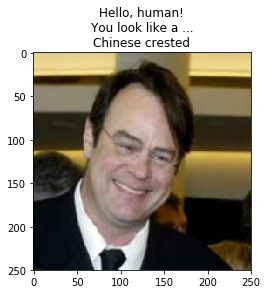

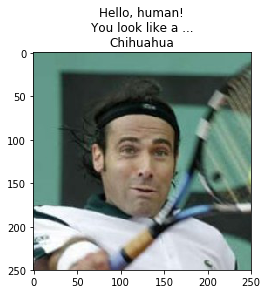

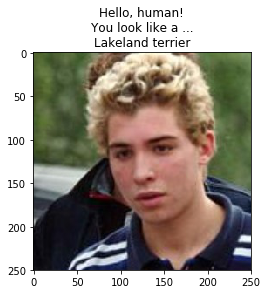

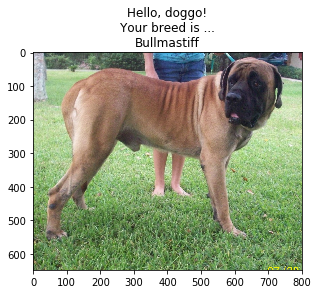

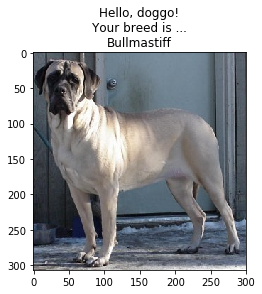

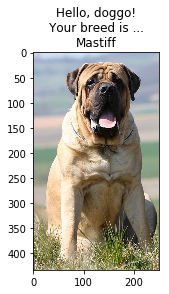

In [31]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)